# Data cleaning and screening

In [ ]:
pre, code {
  max-height: 500px;
  overflow-y: auto;
  white-space: pre !important; 
  overflow-x: auto
}

In [ ]:
# to detect and warn about conflicts
library(conflicted)

conflict_prefer("filter", "dplyr")

[conflicted] Will prefer dplyr::filter over any other package.

[conflicted] Will prefer dplyr::select over any other package.

[conflicted] Will prefer dplyr::slice over any other package.

In [ ]:
# to read in data
library(readr)

path_nids <- "_data/data_process"
path_ready <- "_data/data_ready"

# for data wrangling and cleaning
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1

In [ ]:
baseline <- read_csv(here::here(path_nids,"baseline_nid.csv"), 
                     show_col_types = FALSE)

base_sona <- read_csv(here::here(path_nids,"baseline_sona_id.csv"), 
                     show_col_types = FALSE)

data <- read_csv(here::here(path_nids, "diary_nid.csv"), col_types = cols(
  StartDate = col_character(),
  EndDate = col_character(),
  RecordedDate = col_character(),
  AuDB4 = col_character(),
  AuDB4_7_TEXT = col_character(),
  AuDB5 = col_character(),
  AuDB5_6_TEXT = col_character(),
  Q186 = col_character(),
  Q186_8_TEXT = col_character(),
  PSB2 = col_character(),
  Q211 = col_character(),
  PSB15 = col_character(),
  OSBB2 = col_character(),
  OSBB6 = col_character(),
  OSBB10_11 = col_character(),
  SSAB3 = col_character(),
  SSAB6_7 = col_character(),
  Q215 = col_character())) %>%
    clean_names() %>%
    glimpse()

e.g.:
  dat <- vroom(...)
  problems(dat)

Rows: 6,928
Columns: 191
$ start_date            <chr> "2022-10-19 10:11:09", "2022-10-19 11:10:25", "2…
$ end_date              <chr> "2022-10-19 10:13:50", "2022-10-19 11:11:32", "2…
$ status                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ip_address            <chr> "72.33.2.202", "35.148.93.36", "72.33.2.165", "7…
$ progress              <dbl> 100, 100, 100, 100, 100, 100, 100, 100, 100, 100…
$ duration_in_seconds   <dbl> 160, 66, 84, 151, 103, 105, 66, 92, 121, 171, 48…
$ finished              <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ recorded_date         <chr> "2022-10-19 10:13:50", "2022-10-19 11:11:32", "2…
$ response_id           <chr> "R_0kqlvefI2O3z3cR", "R_2c1Nih6gyoqYPMo", "R_2sc…
$ recipient_last_name   <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ recipient_first_name  <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ recipient_email       <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ external_refe

## Initial cleaning

Format dates

In [ ]:
data <- data %>% 
  mutate(start_date = as_datetime(start_date, tz = "America/Chicago"),
         end_date = as_datetime(end_date, tz = "America/Chicago"),
         recorded_date = as_datetime(recorded_date, tz = "America/Chicago"),
         date = date(start_date))

Confirm participant identifiers

In [ ]:
nrow(data) # 6928

[1] 6928

[1] 278

[1] 278

### Remove blank surveys

Remove 136 completely blank surveys

In [ ]:
data_empty <- data %>% 
  select(au_db1:e4) 

data_empty_rows <- which(rowSums(is.na(data_empty)) == ncol(data_empty))

length(data_empty_rows)

[1] 136

### Identify duplicates

255 duplicates (i.e., more than one survey on same day for one pid)

In [ ]:
data %>% 
  group_by(pid, date) %>% 
  count() %>% 
   ungroup() %>% 
  filter(n > 1) %>% 
  arrange(desc(n))

# A tibble: 255 × 3
            pid date           n
          <dbl> <date>     <int>
 1 102322233822 2022-11-18     4
 2 101922110450 2022-11-01     3
 3 101922140746 2022-10-23     3
 4 101922140746 2022-10-26     3
 5 101922141125 2022-10-21     3
 6 101922210432 2022-10-24     3
 7 102022122815 2022-10-29     3
 8 102322233822 2022-11-15     3
 9 102622130043 2022-11-16     3
10 102722110650 2022-11-19     3
# ℹ 245 more rows

Check if responses are same on duplicates

In [ ]:
duplicates <- data %>% 
  group_by(pid, date) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 1) %>% 
  left_join(data, by = c("pid", "date")) %>% 
  filter(!is.na(n)) 

duplicates %>% 
  distinct() %>% 
  nrow() 

[1] 521

[1] 462

Remove duplicates that are same on all columns except survey metadata  
Will keep first survey so we have start time of first survey that day

In [ ]:
duplicate_responses <- which(duplicates %>% 
  select(-c(4:20)) %>% 
  duplicated())

duplicate_ids <- duplicates %>% 
  filter(row_number() %in% duplicate_responses) %>% 
  pull(response_id)

data <- data %>% 
  filter(!response_id %in% duplicate_ids)

Left with 197 duplicate surveys

In [ ]:
data %>% 
  group_by(pid, date) %>% 
  count() %>% 
   ungroup() %>% 
  filter(n > 1) %>% 
  arrange(desc(n))

# A tibble: 197 × 3
            pid date           n
          <dbl> <date>     <int>
 1 102322233822 2022-11-18     4
 2 101922110450 2022-11-01     3
 3 101922140746 2022-10-23     3
 4 101922140746 2022-10-26     3
 5 101922141125 2022-10-21     3
 6 101922210432 2022-10-24     3
 7 102022122815 2022-10-29     3
 8 102322233822 2022-11-15     3
 9 102622130043 2022-11-16     3
10 101922110450 2022-10-24     2
# ℹ 187 more rows

Check for duplicate surveys with no data other than screening questions for branching

In [ ]:
data_empty <- duplicates %>% 
  select(au_db2:e4) 

data_empty_rows <- which(rowSums(is.na(data_empty)) == ncol(data_empty))

duplicates %>% 
  filter(row_number() %in% data_empty_rows) %>%
  group_by(nid, date) %>%
  count() %>% 
  arrange(desc(n))

# A tibble: 40 × 3
# Groups:   nid, date [40]
       nid date           n
     <dbl> <date>     <int>
 1 5140108 2022-11-16     2
 2 1083617 2022-11-12     1
 3 1215369 2022-11-06     1
 4 1345823 2022-11-12     1
 5 1636530 2022-10-31     1
 6 2148675 2022-11-07     1
 7 2531227 2022-11-01     1
 8 3187228 2022-10-25     1
 9 3279665 2022-11-03     1
10 3313178 2022-10-27     1
# ℹ 30 more rows

# A tibble: 3 × 193
           pid date           n start_date          end_date            status
         <dbl> <date>     <int> <dttm>              <dttm>               <dbl>
1 102622130043 2022-11-16     3 2022-11-16 11:24:31 2022-11-16 11:25:36      0
2 102622130043 2022-11-16     3 2022-11-16 11:23:19 2022-11-16 11:23:30      0
3 102622130043 2022-11-16     3 2022-11-16 11:23:55 2022-11-16 11:24:10      0
# ℹ 187 more variables: ip_address <chr>, progress <dbl>,
#   duration_in_seconds <dbl>, finished <dbl>, recorded_date <dttm>,
#   response_id <chr>, recipient_last_name <lgl>, recipient_first_name <lgl>,
#   recipient_email <lgl>, external_reference <lgl>, location_latitude <dbl>,
#   location_longitude <dbl>, distribution_channel <chr>, user_language <chr>,
#   au_db1 <dbl>, psb1 <dbl>, osbb1 <dbl>, ssab1 <dbl>, drugs_screen_fu <dbl>,
#   bpa1 <dbl>, porn_screen_fu <dbl>, au_db2 <dbl>, au_db3 <dbl>, …

filter out mostly blank duplicates (i.e., only responded to branching questions and have more complete survey on same day)

In [ ]:
response_ids <- duplicates %>% 
  filter(row_number() %in% data_empty_rows) %>% 
  pull(response_id)

data <- data %>% 
  filter(!response_id %in% response_ids)

159 duplicates left

In [ ]:
data %>% 
  group_by(pid, date) %>% 
  count() %>% 
   ungroup() %>% 
  filter(n > 1) %>% 
  arrange(desc(n))

# A tibble: 159 × 3
            pid date           n
          <dbl> <date>     <int>
 1 102322233822 2022-11-18     4
 2 101922110450 2022-11-01     3
 3 101922140746 2022-10-23     3
 4 101922140746 2022-10-26     3
 5 101922141125 2022-10-21     3
 6 102322233822 2022-11-15     3
 7 101922110450 2022-10-24     2
 8 101922110450 2022-10-30     2
 9 101922110450 2022-11-07     2
10 101922130136 2022-10-20     2
# ℹ 149 more rows

Look at surveys taken at midnight to see if date is incorrect due to being slightly after midnight

In [ ]:
data %>% 
  filter(hour(start_date) < 2) %>% 
  select(nid, start_date)

# A tibble: 8 × 2
      nid start_date         
    <dbl> <dttm>             
1 9796568 2022-10-29 00:03:52
2 9740303 2022-10-29 00:14:23
3 6681525 2022-11-06 00:14:55
4 3256800 2022-11-10 01:01:05
5 3256800 2022-11-10 01:01:51
6 9328313 2022-11-11 00:10:54
7 2564475 2022-11-13 00:57:58
8 8311815 2022-11-15 00:14:07

5/8 Duplicate surveys taken at midnight and later that night and are missing survey day before- determined midnight survey was for previous day. Correcting new date variable here.

Note: this date variable lines up roughly to day on study

In [ ]:
# data %>% 
#   filter(nid == "9796568") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)
# 
# data %>% 
#   filter(nid == "9740303") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)
# 
# data %>% 
#   filter(nid == "6681525") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)
# 
# data %>% 
#   filter(nid == "3256800") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)
# 
# data %>% 
#   filter(nid == "9328313") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)
# 
# data %>% 
#   filter(nid == "2564475") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)
# 
# data %>% 
#   filter(nid == "8311815") %>% 
#   select(date, response_id, start_date) %>% 
#   print(n = Inf)

data <- data %>% 
  mutate(date = if_else(response_id == "R_28GUR3cJzRXaTPC", date("2022-11-10"), 
                        date),
         date = if_else(response_id == "R_3lEREAWesaFQSnG", date("2022-10-28"),
                        date),
         date = if_else(response_id == "R_21G38UK4RkS5Ky5", date("2022-10-28"),
                        date),
         date = if_else(response_id == "R_2q1tWYtBw0XbZlM", date("2022-11-05"),
                        date),
         date = if_else(response_id == "R_2c63k6bRzLwkyJT", date("2022-11-14"),
                        date))

Look at differences in branching questions among duplicates

In [ ]:
duplicates <- data %>% 
  group_by(pid, date) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 1) %>% 
  left_join(data, by = c("pid", "date")) %>% 
  filter(!is.na(n)) 

duplicates_branch_match <- duplicates %>% 
  select(nid, date, au_db1:porn_screen_fu) %>% 
  distinct() %>% 
  group_by(nid, date) %>% 
  count() %>% 
  filter(n == 1) %>% 
  select(-n) %>% 
  left_join(duplicates, by = c("nid", "date"))

Look at mental health questions

In [ ]:
duplicates_branch_match %>% 
  filter(au_db1 == 2 & psb1 == 2 & osbb1 == 2 & ssab1 == 2 & 
                 drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 2) %>% 
  select(nid, date, response_id, start_date, mis1:e4) %>% 
  glimpse()

Rows: 165
Columns: 18
Groups: nid, date [82]
$ nid                  <dbl> 1215369, 1215369, 1419718, 1419718, 1428771, 1428…
$ date                 <date> 2022-11-05, 2022-11-05, 2022-10-28, 2022-10-28, …
$ response_id          <chr> "R_2ZC8HYrCFZZnlIA", "R_2OMVgMmsh0PCohX", "R_XFce…
$ start_date           <dttm> 2022-11-05 16:50:30, 2022-11-05 16:53:09, 2022-1…
$ mis1                 <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3…
$ mis2                 <dbl> 4, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3…
$ mis3                 <dbl> 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 3…
$ mis4                 <dbl> 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3…
$ phq8_1_fu            <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, NA, 0, 0, …
$ phq8_2_fu            <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, NA, 0, 0, …
$ phq8_3_fu            <dbl> 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, NA, 1, 2, …
$ phq8_4_fu            <dbl> 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 0, NA, 1, 

If answers same keep more complete survey then first survey

In [ ]:
data <- data %>% 
  filter(!response_id %in% c("R_3nl1aO9wz2HoliI", "R_3j0cQeVBMt5s0Y0",
         "R_27UvVfdaNbLQIvA", "R_1roCa7SNA64ll6b", "R_3JjZhfFzAc87KLQ",
         "R_3eb3ZXUu8ma62HW", "R_1goOMvxm2OO37xE", "R_2anOsrKT0rWfpyh",
         "R_2v7x6suXsPA7lCE", "R_3n1q190pGvgnJvW", "R_3Mmsiry2UFC250F",
         "R_1CD8AVjRYbvFOSE", "R_1pGNAcQtKqkDl4Y", "R_1Kp50zwQe1EHJ9A"))

If answers differ only by 1-2 items, keep more complete survey or if both complete keep first survey

In [ ]:
data <- data %>% 
  filter(!response_id %in% c("R_2e3FNxw2bfXqVhD", "R_3PuSSFXqM2rg75H",
                             "R_21jN639l8fmHhv7", "R_24cL375YzQDqcNs",
                             "R_27InzwQuaYLA91G", "R_2q3iIQW0ju1U0TC",
                             "R_2aQz1zTeseotOnq", "R_aYqSgHFF1qJem9r",
                             "R_1mI5Ldgr8fNIDJn", "R_5mZeozvhOLfQHyF",
                             "R_3G2MmYKXMfOPpw8", "R_12hVYRgqDPJX7KM",
                             "R_V418rtMyfoi5rTb", "R_1zfPXLu96CO1qfv", 
                             "R_1FOH5eJeKZKDLaE", "R_vMHmj0vxM2bn98R",
                             "R_1lt7qIcUoYRj7s2", "R_vAMr55UaumNxt9n",
                             "R_xbVy68nr7ZEHK01", "R_12QL6qI8bCV2YPL",
                             "R_3rZiJxcPpT5dgx4", "R_27PDNNBEMijZqxM",
                             "R_3FJ7693Okhf5xgn", "R_DFXWiS5oKvsSevn",
                             "R_uxoQLKB3iUwZvJ7", "R_5aMdcpvNUaRgepH",
                             "R_1GWuG4iIs1EgIdy", "R_3nUxYS964qGdnyn",
                             "R_1jIj5b2QDOMaSgO", "R_2QFE8b5dMtmd3JL",
                             "R_ZjK1J5cruthIO6R", "R_1kZV0eMBz42WEFW",
                             "R_1FfEfAVl19LMXFw", "R_3gZOFZK2937JZqj"))

Look at other matching branch surveys

In [ ]:
# duplicates_branch_match %>% 
#   filter(au_db1 == 1 & psb1 == 2 & osbb1 == 2 & ssab1 == 2 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 2) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 1 & psb1 == 1 & osbb1 == 2 & ssab1 == 2 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 2) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 2 & psb1 == 2 & osbb1 == 1 & ssab1 == 1 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 2) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 2 & psb1 == 2 & osbb1 == 2 & ssab1 == 1 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 2) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 2 & psb1 == 2 & osbb1 == 2 & ssab1 == 1 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 1) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 2 & psb1 == 1 & osbb1 == 2 & ssab1 == 1 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 1) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 1 & psb1 == 2 & osbb1 == 2 & ssab1 == 2 & 
#                  drugs_screen_fu == 2 & bpa1 == 1 & porn_screen_fu == 2) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()
# 
# duplicates_branch_match %>% 
#   filter(au_db1 == 2 & psb1 == 2 & osbb1 == 1 & ssab1 == 2 & 
#                  drugs_screen_fu == 2 & bpa1 == 2 & porn_screen_fu == 1) %>% 
#   select(nid, date, response_id, start_date, au_db2:e4) %>% 
#   view()

If answers differ only by 1-2 items (or 3 items if more than one branch endorsed and completed), keep more complete survey or if both complete keep first survey

In [ ]:
data <- data %>% 
  filter(!response_id %in% c("R_1DYDNJfbNuwRivW", "R_3w9vDPa7Aoq1lFD",
                             "R_22Gkq3271dAoUP2", "R_1gTtr4rJocjW0Uy",
                             "R_2uJW6wj5ne3i1wS", "R_3MGuKFZITFIe3NM",
                             "R_3MDR4RbykC162QV", "R_3Gq3wQfAmpYVFit",
                             "R_3Mn9DViM1ZJlQ1Q", "R_3dYXmYQcqJbtXbD",
                             "R_Ww9Ie3dTvQ58QbT", "R_1OVRbIUU6JzciJI",
                             "R_1P1q8xsYV2BQ3KG", "R_DclSImfNg9xma6B",
                             "R_3s17B90hYoNIXpy", "R_3Lb7H5oppSanIB0",
                             "R_Aafzxghrkp8ZNEl"))

Look at non-matching branch surveys

In [ ]:
duplicates %>% 
  filter(!response_id %in% duplicates_branch_match$response_id) %>% 
  select(nid, date, response_id, start_date, au_db1:e4) %>% 
  glimpse()

Rows: 97
Columns: 167
$ nid                   <dbl> 8617355, 8617355, 8617355, 8617355, 8617355, 546…
$ date                  <date> 2022-10-24, 2022-10-24, 2022-11-01, 2022-11-01,…
$ response_id           <chr> "R_2wjejBG6wLUiPND", "R_aWWayxdHVI4j6Lv", "R_1eJ…
$ start_date            <dttm> 2022-10-24 12:10:47, 2022-10-24 20:04:44, 2022-…
$ au_db1                <dbl> 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 1, 2, 2, 2, 2, …
$ psb1                  <dbl> 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, …
$ osbb1                 <dbl> 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, …
$ ssab1                 <dbl> 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, …
$ drugs_screen_fu       <dbl> 2, 2, 2, 2, 1, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ bpa1                  <dbl> 2, 2, 2, 2, 2, 2, 4, 2, 2, 1, 1, 2, 2, 2, 2, 2, …
$ porn_screen_fu        <dbl> 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, …
$ au_db2                <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, 3, 2, 2, NA,…
$ au_db3          

Duplicates by nid

In [ ]:
# total duplicates
duplicates %>% 
  group_by(nid) %>% 
  count() %>% 
  arrange(desc(n))

# A tibble: 92 × 2
# Groups:   nid [92]
       nid     n
     <dbl> <int>
 1 9478839    18
 2 6208949    17
 3 5462581    10
 4 8617355     9
 5 7459356     8
 6 8057415     8
 7 3256800     6
 8 3279665     6
 9 4101260     6
10 6165526     6
# ℹ 82 more rows

# A tibble: 92 × 2
# Groups:   nid [92]
       nid     n
     <dbl> <int>
 1 9478839     9
 2 6208949     7
 3 5462581     4
 4 7459356     4
 5 8057415     4
 6 8617355     4
 7 3256800     3
 8 3279665     3
 9 4101260     3
10 6165526     3
# ℹ 82 more rows

99 duplicates remaining

In [ ]:
duplicates <- data %>% 
  group_by(pid, date) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 1) %>% 
  left_join(data, by = c("pid", "date")) %>% 
  filter(!is.na(n)) 

data %>% 
  group_by(pid, date) %>% 
  count() %>% 
   ungroup() %>% 
  filter(n > 1) %>% 
  arrange(desc(n)) %>% 
  print(n = Inf)

# A tibble: 99 × 3
            pid date           n
          <dbl> <date>     <int>
 1 101922110450 2022-11-01     3
 2 101922141125 2022-10-21     3
 3 102322233822 2022-11-15     3
 4 101922110450 2022-10-24     2
 5 101922110450 2022-10-30     2
 6 101922110450 2022-11-07     2
 7 101922130136 2022-10-20     2
 8 101922135243 2022-10-20     2
 9 101922140746 2022-10-23     2
10 101922140746 2022-10-24     2
11 101922140746 2022-10-25     2
12 101922140746 2022-10-26     2
13 101922141904 2022-11-03     2
14 101922141904 2022-11-12     2
15 101922142835 2022-10-23     2
16 101922142835 2022-11-05     2
17 101922143628 2022-10-30     2
18 101922143628 2022-11-07     2
19 101922153307 2022-10-28     2
20 101922153946 2022-10-28     2
21 101922155342 2022-10-22     2
22 101922155342 2022-11-08     2
23 101922161011 2022-11-05     2
24 101922161011 2022-11-15     2
25 101922171124 2022-10-24     2
26 101922182323 2022-11-09     2
27 101922185710 2022-10-21     2
28 101922193304 2022-10-

------------------------------------------------------------------------

Manually inspected remaining duplicates

Check how much time between duplicate surveys

In [ ]:
duplicates %>% 
  group_by(nid, date) %>% 
  summarize(time_between_dups = max(start_date) - min(start_date)) %>% 
  arrange(time_between_dups) %>% 
  print(n = Inf)

`summarise()` has grouped output by 'nid'. You can override using the `.groups`
argument.

# A tibble: 99 × 3
# Groups:   nid [64]
       nid date       time_between_dups
     <dbl> <date>     <drtn>           
 1 6691463 2022-10-28    35 secs       
 2 9763528 2022-11-01    37 secs       
 3 8057415 2022-11-15    38 secs       
 4 1419718 2022-10-28    41 secs       
 5 2543679 2022-11-03    41 secs       
 6 9478839 2022-11-04    43 secs       
 7 1215369 2022-11-15    44 secs       
 8 7971058 2022-11-03    44 secs       
 9 3256800 2022-11-10    46 secs       
10 9478839 2022-11-10    46 secs       
11 6616681 2022-11-11    48 secs       
12 8057415 2022-11-01    48 secs       
13 9478839 2022-11-03    48 secs       
14 2050073 2022-11-08    51 secs       
15 9478839 2022-10-29    51 secs       
16 7036968 2022-11-20    54 secs       
17 6208949 2022-11-19    55 secs       
18 7924523 2022-11-12    56 secs       
19 9478839 2022-11-17    57 secs       
20 9763528 2022-11-04    60 secs       
21 5534031 2022-11-05    61 secs       
22 6927064 2022-10-20    66 secs       


Look at duplicates more than 3 hours apart (3600 seconds = 1 hour)

In [ ]:
duplicates %>% 
  group_by(nid, date) %>% 
  summarize(time_between_dups = max(start_date) - min(start_date)) %>% 
  arrange(time_between_dups) %>% 
  filter(time_between_dups > 10800) %>% 
  print(n = Inf)

`summarise()` has grouped output by 'nid'. You can override using the `.groups`
argument.

# A tibble: 38 × 3
# Groups:   nid [28]
       nid date       time_between_dups
     <dbl> <date>     <drtn>           
 1 5462581 2022-10-26 11530 secs       
 2 6208949 2022-11-02 13774 secs       
 3 3130104 2022-10-28 15103 secs       
 4 5462581 2022-10-24 15562 secs       
 5 8057415 2022-11-02 17262 secs       
 6 5462663 2022-10-20 18403 secs       
 7 6208949 2022-11-05 18980 secs       
 8 6208949 2022-11-16 19558 secs       
 9 8617355 2022-10-30 20230 secs       
10 8061889 2022-10-24 20516 secs       
11 6263279 2022-10-30 20968 secs       
12 1083617 2022-11-24 22039 secs       
13 2940696 2022-11-02 22439 secs       
14 1697880 2022-10-22 22633 secs       
15 4106122 2022-10-23 23624 secs       
16 6208949 2022-11-15 24343 secs       
17 8617355 2022-11-07 24360 secs       
18 1836643 2022-11-06 25095 secs       
19 4990422 2022-11-10 25856 secs       
20 1697880 2022-11-08 26610 secs       
21 3402989 2022-10-29 26941 secs       
22 2342070 2022-11-06 27881 secs       


`summarise()` has grouped output by 'nid'. You can override using the `.groups`
argument.

Rows: 77
Columns: 194
$ nid                   <dbl> 1083617, 1083617, 1083617, 1083617, 1636530, 163…
$ date                  <date> 2022-11-13, 2022-11-13, 2022-11-24, 2022-11-24,…
$ response_id           <chr> "R_d0WuHXIYc3QHGyl", "R_XLmafrkiyofjB4t", "R_2OS…
$ progress              <dbl> 100, 100, 100, 100, 100, 100, 100, 100, 100, 37,…
$ time_between_dups     <drtn> 32404 secs, 32404 secs, 22039 secs, 22039 secs,…
$ pid                   <dbl> 110122233630, 110122233630, 110122233630, 110122…
$ n                     <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ start_date            <dttm> 2022-11-13 12:31:33, 2022-11-13 21:31:37, 2022-…
$ end_date              <dttm> 2022-11-13 12:32:15, 2022-11-13 21:32:11, 2022-…
$ status                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ ip_address            <chr> "172.225.24.65", "104.28.104.62", "172.225.216.2…
$ duration_in_seconds   <dbl> 42, 34, 60, 29, 44, 37, 121, 45, 59, 26, 39, 47,…
$ finished        

In [ ]:
data <- data %>% 
  filter(!response_id %in% c("R_117vFnoNfgFOk4D", "R_d0WuHXIYc3QHGyl",
                             "R_2OSU9MciQO5OGhT"))

If progress \< 100 and another is 100 remove \< 100 duplicate

In [ ]:
data <- data %>% 
  filter(!response_id %in% c("R_3PzBQDOn70O3RHN", "R_2VgBsuP6FAg18p7", 
                             "R_2ZQxY4bcYnHkKVT", "R_2ANi9iaiZrRiK7W",
                             "R_zYcdQAFTkd4Wf85", "R_2RUMEtkgHOoKiU9",
                             "R_0HP8PsuElUEqq4N", "R_2DZw0MQSQ4Zv2M6",
                             "R_1Dqyd9EAWF6zkGf", "R_12KJL68mIqMDtil",
                             "R_3szg3OAQjR1LWAS", "R_2t36lXAL1Zxe8VG",
                             "R_ZIBMUETiZP7IX2F", "R_1JDaJzJxE3tFhJM",
                             "R_2s0dOdGygUSWdln", "R_2ysynCwzs7kOGy7",
                             "R_cIyJ7yF1Re01kC5", "R_3MPXwxSXDlhGQaI"))

In [ ]:
duplicates <- data %>% 
  group_by(pid, date) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 1) %>% 
  left_join(data, by = c("pid", "date")) %>% 
  filter(!is.na(n)) 

data %>% 
  group_by(nid, date) %>% 
  count() %>% 
   ungroup() %>% 
  filter(n > 1) %>% 
  arrange(desc(n)) %>% 
  print(n = Inf)

# A tibble: 81 × 3
       nid date           n
     <dbl> <date>     <int>
 1 1215369 2022-11-05     2
 2 1215369 2022-11-15     2
 3 1419718 2022-10-28     2
 4 1636530 2022-11-02     2
 5 1661366 2022-10-22     2
 6 1697880 2022-10-22     2
 7 1836643 2022-11-06     2
 8 2050073 2022-11-08     2
 9 2050073 2022-11-13     2
10 2342070 2022-10-26     2
11 2342070 2022-11-06     2
12 2367248 2022-10-30     2
13 2408372 2022-10-21     2
14 2460338 2022-11-12     2
15 2540837 2022-10-26     2
16 2543679 2022-11-03     2
17 2564475 2022-11-13     2
18 3256800 2022-11-10     2
19 3256800 2022-11-14     2
20 3279665 2022-11-04     2
21 3402989 2022-10-29     2
22 3992191 2022-10-26     2
23 4101260 2022-10-30     2
24 4101260 2022-11-07     2
25 4106122 2022-10-23     2
26 4133427 2022-11-14     2
27 4145153 2022-11-09     2
28 4990422 2022-11-10     2
29 5462581 2022-10-23     2
30 5462581 2022-10-24     2
31 5462581 2022-10-25     2
32 5462581 2022-10-26     2
33 5534031 2022-10-23     2
3

For final ones, keep first survey (no way to determine which one is more accurate)

In [ ]:
first_surveys <- duplicates %>% 
  group_by(nid, date) %>% 
  arrange(date) %>% 
  slice(1)


data <- data %>% 
  filter((response_id %in% duplicates$response_id & !response_id %in% first_surveys$response_id) | (response_id %in% data$response_id & !response_id %in% duplicates$response_id))

All duplicates resolved

In [ ]:
duplicates <- data %>% 
  group_by(pid, date) %>% 
  count() %>% 
  ungroup() %>% 
  filter(n > 1) %>% 
  left_join(data, by = c("pid", "date")) %>% 
  filter(!is.na(n)) 

data %>% 
  group_by(nid, date) %>% 
  count() %>% 
   ungroup() %>% 
  filter(n > 1) %>% 
  arrange(desc(n)) %>% 
  print(n = Inf)

# A tibble: 0 × 3
# ℹ 3 variables: nid <dbl>, date <date>, n <int>

### Check number of surveys per unique participant

In [ ]:
data %>% 
  group_by(nid) %>% 
  count() %>% 
  arrange(desc(n)) %>% 
  print(n = Inf)

# A tibble: 278 × 2
# Groups:   nid [278]
        nid     n
      <dbl> <int>
  1 1116912    28
  2 1233417    28
  3 1345823    28
  4 1380031    28
  5 1467855    28
  6 1511672    28
  7 1647832    28
  8 1825351    28
  9 1990323    28
 10 2342070    28
 11 2366456    28
 12 2408372    28
 13 2438808    28
 14 2460338    28
 15 2498010    28
 16 2533661    28
 17 2543679    28
 18 2556255    28
 19 2593949    28
 20 2599578    28
 21 2661324    28
 22 2670563    28
 23 2910945    28
 24 2940696    28
 25 3022217    28
 26 3172284    28
 27 3318722    28
 28 3327924    28
 29 3335799    28
 30 3529631    28
 31 3891409    28
 32 3992191    28
 33 3996167    28
 34 4145153    28
 35 4246865    28
 36 4446116    28
 37 4657804    28
 38 4806000    28
 39 5140108    28
 40 5192497    28
 41 5324913    28
 42 5331998    28
 43 5450114    28
 44 5651000    28
 45 6131734    28
 46 6165526    28
 47 6274396    28
 48 6421110    28
 49 6502474    28
 50 6519689    28
 51 6596593    28
 52 

#### Mean number of surveys completed: 23.5

In [ ]:
data %>%
  count(nid, name = "n_surveys") %>%
  summarise(
    total_completed = sum(n_surveys),
    total_possible  = n() * 28,
    mean_completed  = mean(n_surveys),
    completion_rate = mean(n_surveys) / 28
  )

# A tibble: 1 × 4
  total_completed total_possible mean_completed completion_rate
            <int>          <dbl>          <dbl>           <dbl>
1            6530           7784           23.5           0.839

# A tibble: 1 × 1
  avg_surveys_completed
                  <dbl>
1                  23.5

# A tibble: 1 × 5
  median_surveys sd_surveys min_surveys max_surveys n_participants
           <dbl>      <dbl>       <int>       <int>          <int>
1             26       6.87           1          28            278

### Rename variables for consistency

In [ ]:
d <- rename_variables(data)

### Remove unnecessary variables

Either added during cleaning for checks or single value metadata columns

In [ ]:
d <- d %>% 
  select(-c(r_date, time, rt, rid, ssid, sms, sig,
            recipient_last_name, recipient_first_name, recipient_email,
            external_reference, distribution_channel, user_language)) %>% 
  relocate(nid, date) %>% 
  glimpse()

Rows: 6,530
Columns: 179
$ nid                 <dbl> 6891674, 9128298, 3533571, 3766694, 9972029, 87052…
$ date                <date> 2022-10-19, 2022-10-19, 2022-10-19, 2022-10-19, 2…
$ start_date          <dttm> 2022-10-19 10:11:09, 2022-10-19 11:10:25, 2022-10…
$ end_date            <dttm> 2022-10-19 10:13:50, 2022-10-19 11:11:32, 2022-10…
$ status              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ ip_address          <chr> "72.33.2.202", "35.148.93.36", "72.33.2.165", "72.…
$ progress            <dbl> 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, …
$ duration_in_seconds <dbl> 160, 66, 84, 151, 103, 105, 66, 92, 121, 171, 484,…
$ finished            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ recorded_date       <dttm> 2022-10-19 10:13:50, 2022-10-19 11:11:32, 2022-10…
$ response_id         <chr> "R_0kqlvefI2O3z3cR", "R_2c1Nih6gyoqYPMo", "R_2scMD…
$ location_latitude   <dbl> 43.0782, 43.0812, 43.0782, 43.0782, 43.0782, 43.07…
$ location_long

Items from online and solo sexual behavior blocks, which fall beyond the scope of current project

In [ ]:
d <- d %>% 
  select(-c(osb2, osb2.txt, osb6:osbb10_11_10_text, osbb15, osbb15_5_text,
            aro_of, pls_of, pss, exp_o, str_o:er4_o, ssb3, ssb3.txt,
            ssb6:er4_s, dub2.txt, med1_d:exp_d, dub3_bf.txt, dub3_du.txt,
            dub3_af.txt, status, q186_8_text, au_l:au_pbs.txt, 
            start_date:end_date, ip_address, recorded_date, 
            location_latitude, location_longitude, group, psb5a, psb6a:str_p.txt, 
            psb7a:psb15_tried_10_text, psb16_10_text:psb16_tried_10_text))

## Recoding for inclusion criteria

### Daily behavioral screeners

1 = Yes, 0 = No, 3 = Prefer not to say

In [ ]:
d <- d %>% 
  mutate(across(aub1:pub1, as.numeric)) %>% 
  mutate(across(c(aub1:psb1, osb1:ssb1, pub1),
               ~if_else(.x == 2, 0, .x)))

d <- d %>%  
  mutate(across(c(dub1:bpa),
               ~case_when(. == 2 ~ 0, 
                          . == 4 ~ 3,
                          TRUE ~ .)))

Dichotomous variables

1 = Yes, 0 = No

In [ ]:
d <- d %>%
  mutate(across(
    c(au_pg, au_dg, prec, er1_p, er2_p, er3_p, er4_p),
    ~ case_when(
      . == "1" ~ 1, # Yes
      . == "2" ~ 0, # No
      TRUE ~ as.numeric(.)
    )
  ))

### Type of sexual activity

`s_act`: What activities occurred? (check all that apply)

Response options:

-   Kissing = 1;
-   Touching = 2;
-   Digital penetration (i.e., w/ fingers) = 3;
-   Oral sex = 4;
-   Vaginal sex = 5;
-   Anal sex = 6;
-   I tried but no sexual contact happened = 7

In [ ]:
d %>% select(s_act) %>% map(tabyl)

$s_act
     .x[[i]]    n      percent valid_percent
           1   65 0.0099540582   0.123106061
         1,2  112 0.0171516080   0.212121212
       1,2,3   24 0.0036753446   0.045454545
     1,2,3,4   29 0.0044410413   0.054924242
   1,2,3,4,5  128 0.0196018377   0.242424242
 1,2,3,4,5,6    1 0.0001531394   0.001893939
   1,2,3,4,6    8 0.0012251149   0.015151515
     1,2,3,5   47 0.0071975498   0.089015152
   1,2,3,5,6    1 0.0001531394   0.001893939
     1,2,3,6    1 0.0001531394   0.001893939
       1,2,4   19 0.0029096478   0.035984848
     1,2,4,5   19 0.0029096478   0.035984848
     1,2,4,6    1 0.0001531394   0.001893939
       1,2,5   13 0.0019908116   0.024621212
       1,3,5    1 0.0001531394   0.001893939
       1,4,5    1 0.0001531394   0.001893939
         1,5    3 0.0004594181   0.005681818
           2   21 0.0032159265   0.039772727
         2,5    1 0.0001531394   0.001893939
       3,4,5    1 0.0001531394   0.001893939
         3,5    1 0.0001531394   0.001893939
   

$s_act
     .x[[i]]    n     percent valid_percent
     Attempt   27 0.004134763    0.05113636
     Contact  198 0.030321593    0.37500000
 Penetration  303 0.046401225    0.57386364
        <NA> 6002 0.919142420            NA

`psb_di` 0 = Attempted sexual contact; 1 = Contact and/or penetration

In [ ]:
d$psb_di <- d$s_act

d <- d %>%   
mutate(across(c(psb_di),
                ~dplyr::recode(.,
                               "Attempt" = 0,
                               "Contact" = 1,
                               "Penetration" = 1)))

d %>% select(psb_di) %>% map(tabyl)

$psb_di
 .x[[i]]    n     percent valid_percent
       0   27 0.004134763    0.05113636
       1  501 0.076722818    0.94886364
      NA 6002 0.919142420            NA

### Subset diary data

To only include obs for which the partnered sexual behavior daily screener (psb1) was endorsed AND sexual contact (psb_di) was reported.

In [ ]:
data_subset <- d %>%
  filter(psb1 == 1 & psb_di == 1)

data_subset %>%
  summarise(
    n_obs = n(),
    n_participants = n_distinct(nid)
  )

# A tibble: 1 × 2
  n_obs n_participants
  <int>          <int>
1   501            152

## Descriptive checks

### Missing diary data

In [ ]:
d <- data_subset %>%
  select(nid, date, response_id, s_act, aro_pf, pls_pf, day,
         verb, enon, inon, prec, fm_r, drink, intox, p_tox, bpa)

colSums(is.na(d))[colSums(is.na(d)) > 0]

aro_pf pls_pf   verb   enon   inon   prec   fm_r  drink 
     2      2      2      2      2      1      2      2 

*Outcomes = Verbal and Nonverbal sexual consent cue use*.

### Verbal consent

To what extent did you do the following during the sexual activity?

`verb`: Directly asked your partner or communicated verbally with your partner about consent

In [ ]:
psych::describe(d$verb)

   vars   n mean   sd median trimmed  mad min max range  skew kurtosis   se
X1    1 499 5.66 4.11      7    5.82 4.45   0  10    10 -0.28     -1.6 0.18

$verb
 .x[[i]]   n     percent valid_percent
       0 121 0.241516966    0.24248497
       1  17 0.033932136    0.03406814
       2  19 0.037924152    0.03807615
       3  25 0.049900200    0.05010020
       4  17 0.033932136    0.03406814
       5  24 0.047904192    0.04809619
       6  18 0.035928144    0.03607214
       7  29 0.057884232    0.05811623
       8  34 0.067864271    0.06813627
       9  29 0.057884232    0.05811623
      10 166 0.331337325    0.33266533
      NA   2 0.003992016            NA

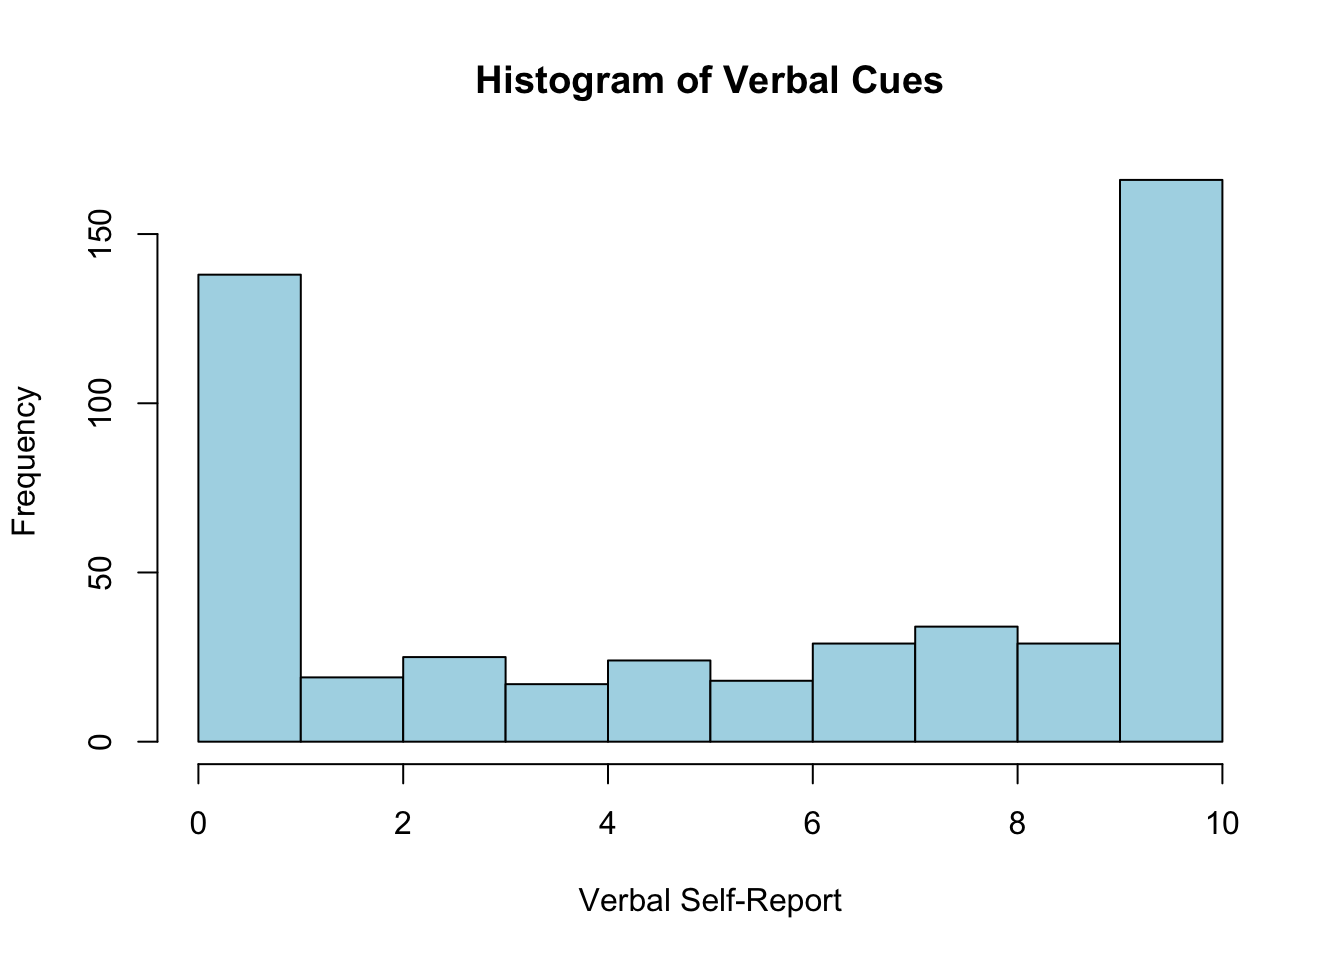

In [ ]:
d %>% select(verb) %>% map(tabyl)

In [ ]:
#### Verbal - Binned for CLMMs

d <- d %>%
  mutate(
    verb_bins = cut(
      verb,
      breaks = c(-Inf, 0, 3, 6, 9, Inf),
      labels = c("Not at all", "A little", 
                 "Somewhat", "Quite a bit", "Very much"),
      right = TRUE,
      include.lowest = TRUE),
    verb_bins = ordered(verb_bins,
                        levels = c("Not at all", "A little", 
                                   "Somewhat", "Quite a bit", "Very much")))

# Verify
is.ordered(d$verb_bins)
table(d$verb_bins, useNA = "ifany")

### Explicit nonverbal

To what extent did you do the following during the sexual activity?

`enon`: Used direct non-verbal signals to communicate with your partner about consent for the sexual activity

In [ ]:
psych::describe(d$enon)

   vars   n mean   sd median trimmed  mad min max range  skew kurtosis   se
X1    1 499 7.07 3.41      8    7.58 2.97   0  10    10 -0.97    -0.36 0.15

$enon
 .x[[i]]   n     percent valid_percent
       0  57 0.113772455   0.114228457
       1   4 0.007984032   0.008016032
       2  13 0.025948104   0.026052104
       3  10 0.019960080   0.020040080
       4  24 0.047904192   0.048096192
       5  32 0.063872255   0.064128257
       6  26 0.051896208   0.052104208
       7  40 0.079840319   0.080160321
       8  56 0.111776447   0.112224449
       9  40 0.079840319   0.080160321
      10 197 0.393213573   0.394789579
      NA   2 0.003992016            NA

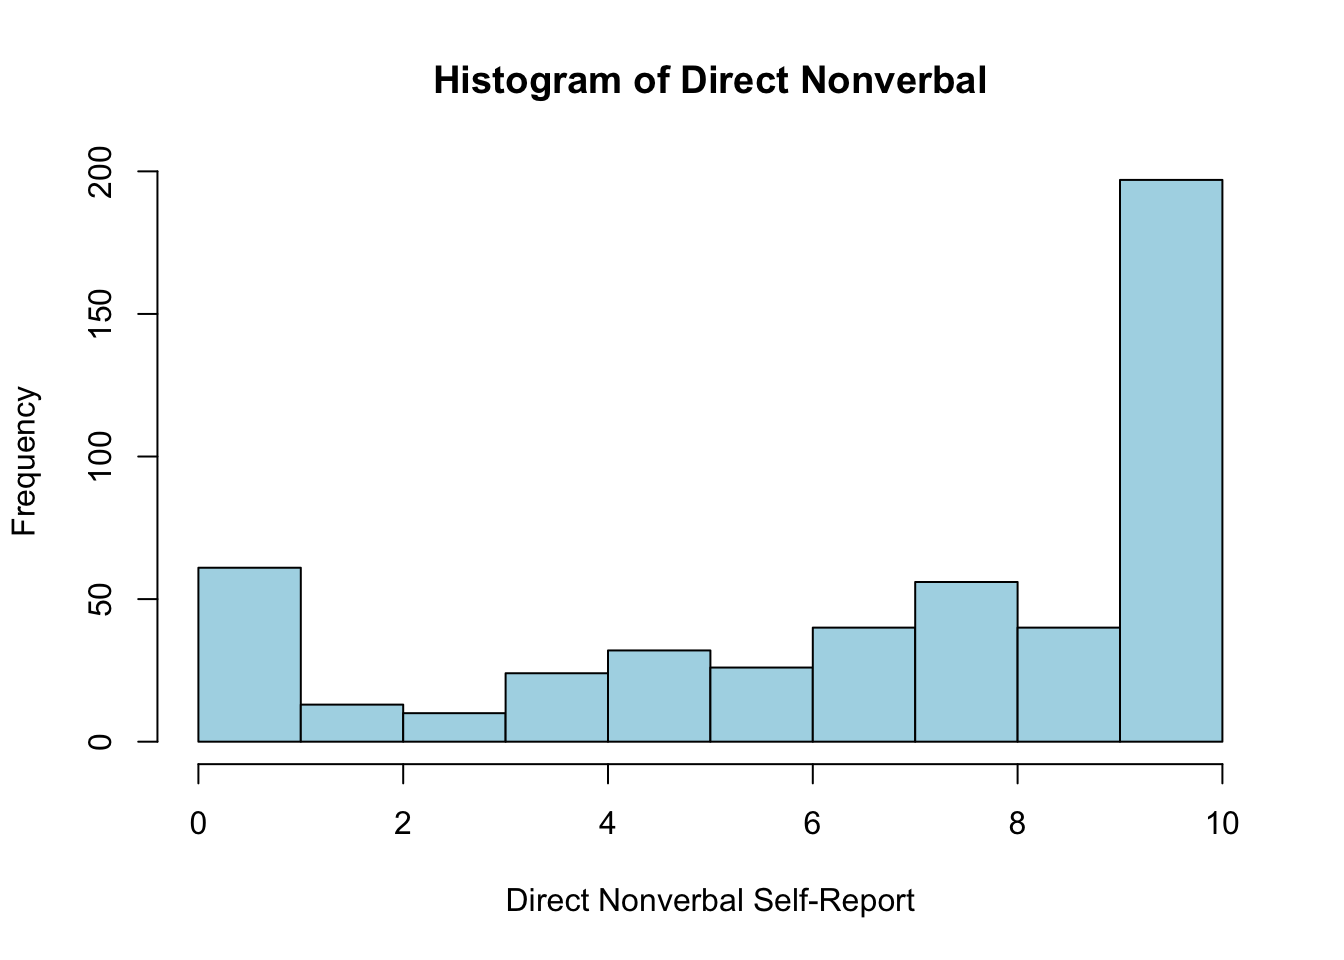

In [ ]:
d %>% select(enon) %>% map(tabyl)

### Implicit nonverbal

To what extent did you do the following during the sexual activity?

`inon_pc`: Used subtle signals to communicate with your partner about consent for the sexual activity

In [ ]:
psych::describe(d$inon)

   vars   n mean   sd median trimmed  mad min max range  skew kurtosis   se
X1    1 499 6.81 3.62      8    7.25 2.97   0  10    10 -0.82    -0.81 0.16

$inon
 .x[[i]]   n     percent valid_percent
       0  66 0.131736527    0.13226453
       1   8 0.015968064    0.01603206
       2  21 0.041916168    0.04208417
       3  18 0.035928144    0.03607214
       4  18 0.035928144    0.03607214
       5  20 0.039920160    0.04008016
       6  28 0.055888224    0.05611222
       7  31 0.061876248    0.06212425
       8  60 0.119760479    0.12024048
       9  33 0.065868263    0.06613226
      10 196 0.391217565    0.39278557
      NA   2 0.003992016            NA

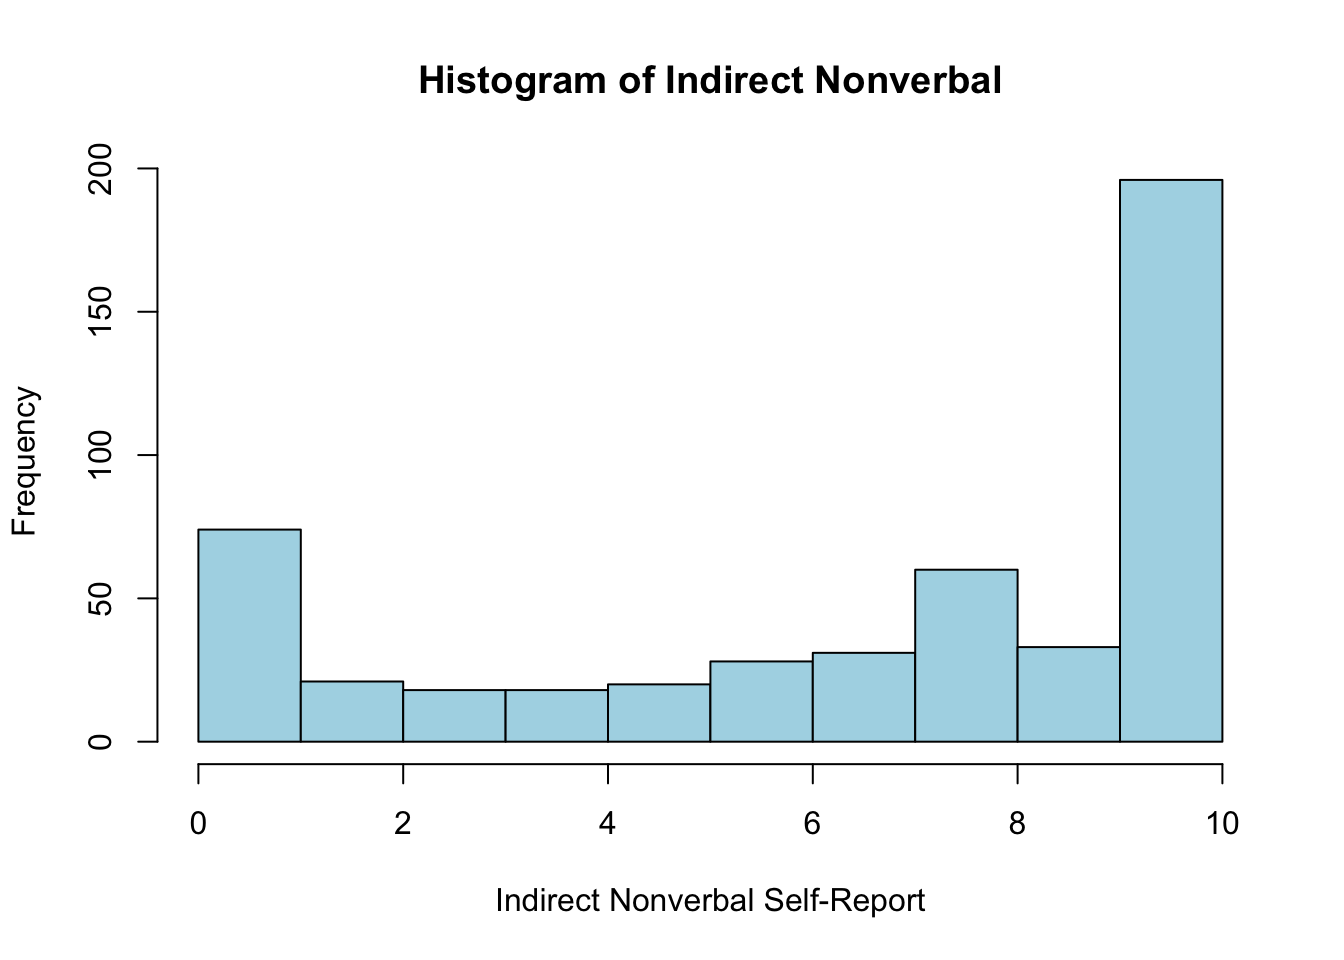

In [ ]:
d %>% select(inon) %>% map(tabyl)

#### Correlation: Explicit - Implicit

In [ ]:
round(cor(d$enon, d$inon, use = "pairwise.complete.obs"), 2)

[1] 0.73

The correlation between the `direct` and `indirect nonverbal` consent cue items was *r* = .73, indicating a strong positive relationship that suggests these items reflect a shared underlying construct. For parsimony and theoretical clarity, these items will be averaged to create a continuous composite score representing overall nonverbal consent communication.

### Nonverbal composite

*Re-calculate post-imputation*

In [ ]:
d <- d %>%
  rowwise() %>%  # calculate mean score
  mutate(nvrb = mean(c(enon,inon)))

psych::describe(d$nvrb)

   vars   n mean   sd median trimmed  mad min max range  skew kurtosis   se
X1    1 499 6.94 3.27      8    7.41 2.97   0  10    10 -0.86    -0.48 0.15

#### Correlation: Verbal - Nonverbal

In [ ]:
# Check correlation between verbal and nonverbal 
round(cor(d$verb, d$nvrb, use = "pairwise.complete.obs"), 2)

[1] 0.12

In [ ]:
#### Nonverbal - Binned for CLMMs
# Create ordered bins for nonverbal consent cues
d <- d %>%
  mutate(
    nonvb_bins = cut(
      nvrb,
      breaks = c(-Inf, 0, 3, 6, 9, Inf),
      labels = c("Not at all", "A little", 
                 "Somewhat", "Quite a bit", "Very much"),
      right = TRUE,
      include.lowest = TRUE
    ),
    nonvb_bins = ordered(nonvb_bins,
                         levels = c("Not at all", "A little", 
                                    "Somewhat", "Quite a bit", "Very much")))
# Verify
is.ordered(d$nonvb_bins)
table(d$nonvb_bins, useNA = "ifany")

### Overview L1 predictors

#### Sexual precedent

`prec`: Had you ever had sexual contact with this person in the past?

No = 0; Yes = 1

In [ ]:
d %>% select(prec) %>% map(tabyl)

$prec
 .x[[i]]   n     percent valid_percent
       0  94 0.187624750         0.188
       1 406 0.810379242         0.812
      NA   1 0.001996008            NA

#### Partner familiarity (raw)

`fm_r`: How did you know this other person?

I didn’t, we just met that day = 1; They are a friend = 2; They are an acquaintance = 3;  
They are my current or past dating/intimate partner = 4

In [ ]:
d %>% select(fm_r) %>% map(tabyl)

$fm_r
 .x[[i]]   n     percent valid_percent
       1  40 0.079840319    0.08016032
       2  96 0.191616766    0.19238477
       3  27 0.053892216    0.05410822
       4 336 0.670658683    0.67334669
      NA   2 0.003992016            NA

#### Participant drink count

`drink`: How many drinks did you consume prior to or during this activity?

Response options: 0 = 1; 1-2 = 2, 3-4 = 3, 5-6 = 4, 7-9 = 5, 10+ = 6

$drink
 .x[[i]]   n     percent valid_percent
       1 311 0.620758483    0.62324649
       2  39 0.077844311    0.07815631
       3  50 0.099800399    0.10020040
       4  48 0.095808383    0.09619238
       5  27 0.053892216    0.05410822
       6  24 0.047904192    0.04809619
      NA   2 0.003992016            NA

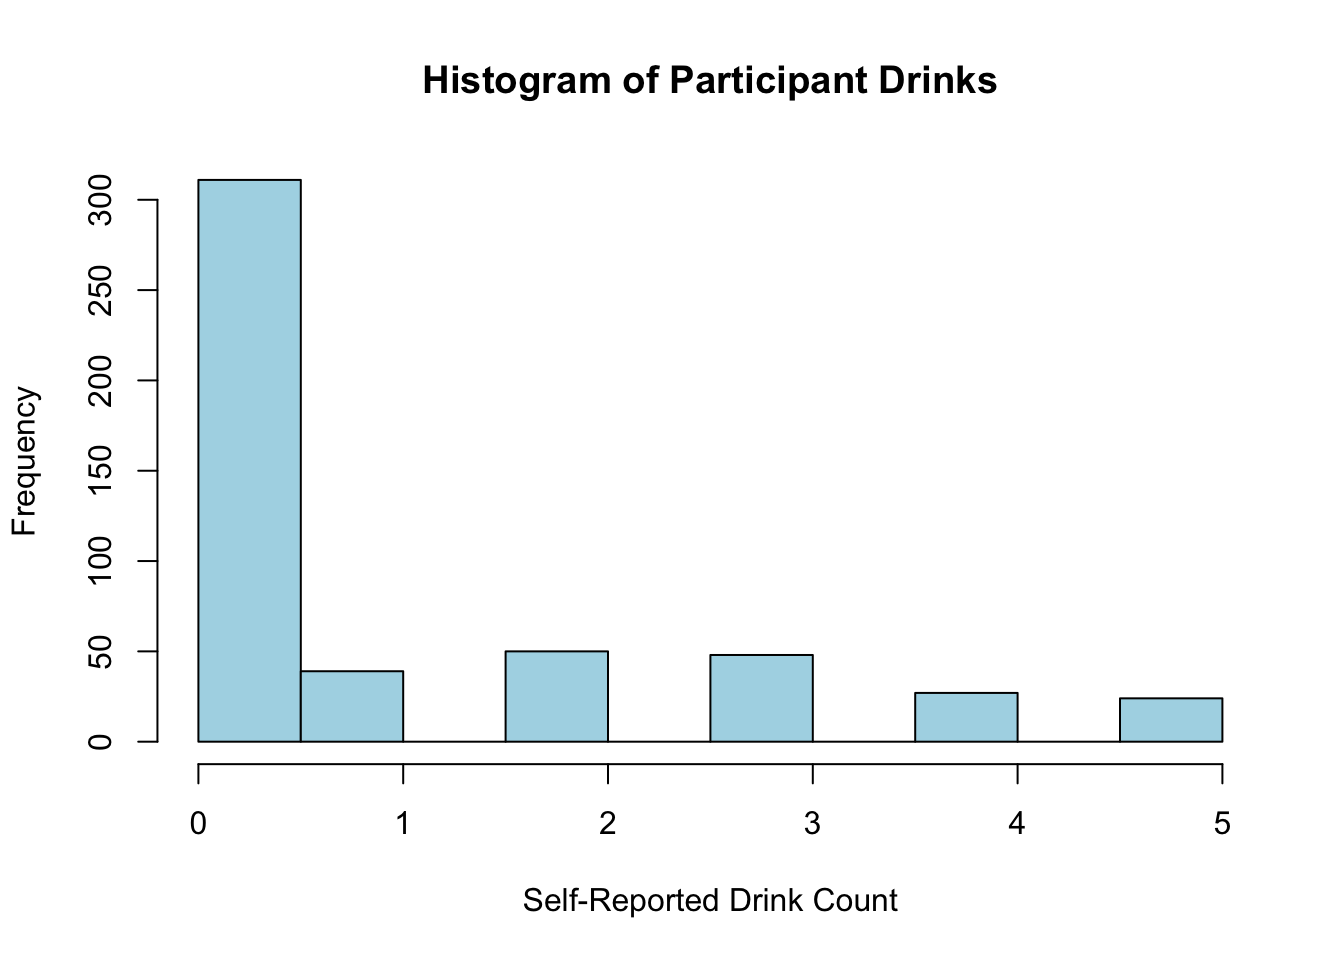

In [ ]:
d %>% select(drink) %>% map(tabyl)

-   Recode `psb_alc` from `drink` such that zero drinks = 0 and \>0 drinks = 1

In [ ]:
d <- d %>%
  mutate(psb_alc = if_else(drink == 1, 0, if_else(drink > 1, 1, drink)))

d %>% select(psb_alc) %>% map(tabyl)

$psb_alc
 .x[[i]]   n     percent valid_percent
       0 350 0.698602794     0.7014028
       1 149 0.297405190     0.2985972
      NA   2 0.003992016            NA

Participants endorsed 149 partnered sexual events following alcohol consumption.

#### Self-reported intoxication

`intox`: How intoxicated did you feel right before or during this sexual activity?

Least intoxicated ever felt in life (0) - Most intoxication ever felt in life (100) VAS

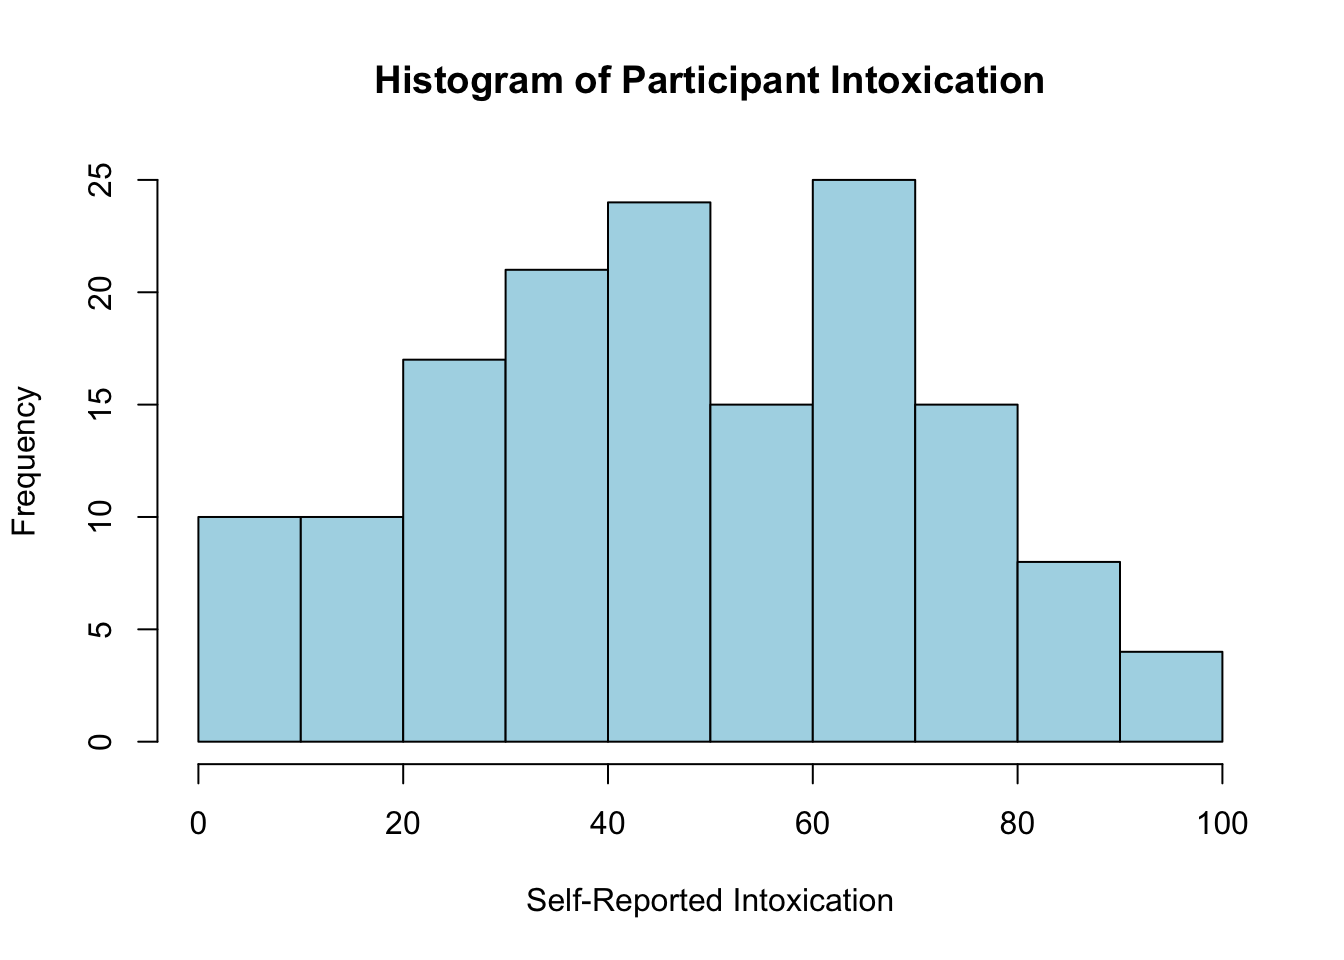

In [ ]:
d %>%
  filter(psb_alc == 1) %>%
  pull(intox) %>%
  hist(main = "Histogram of Participant Intoxication",
       xlab = "Self-Reported Intoxication",
       col = "lightblue",
       breaks = 10)

#### Perceived partner intoxication

`p_tox`: How intoxicated do you think the other person felt right before or during this sexual activity?

Least intoxicated ever felt in life (0) - Most intoxication ever felt in life (100) VAS

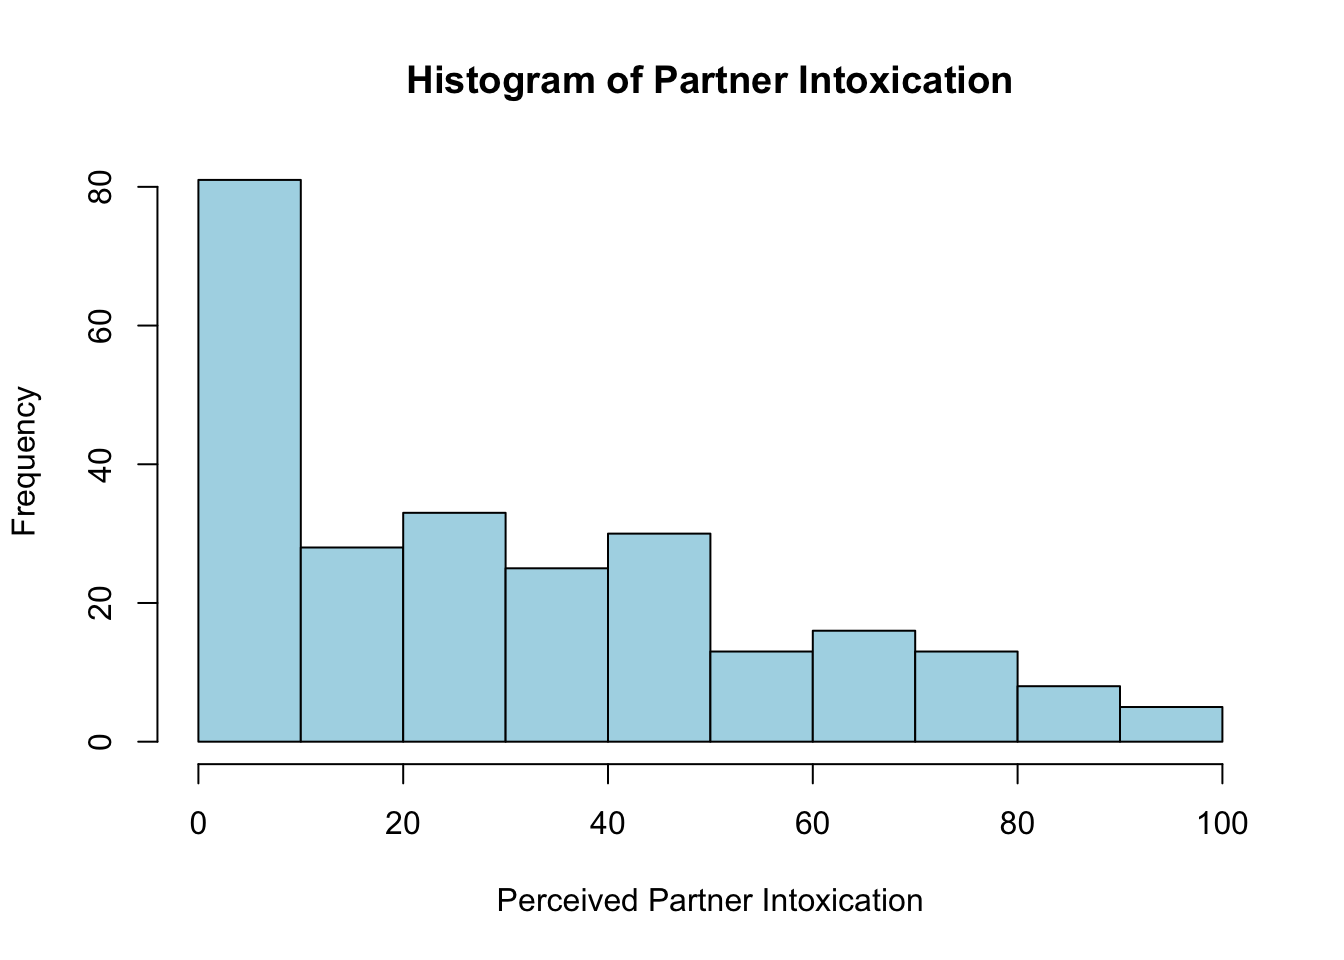

In [ ]:
d %>%
  filter(p_tox > 0) %>%
  pull(p_tox) %>%
  hist(main = "Histogram of Partner Intoxication",
       xlab = "Perceived Partner Intoxication",
       col = "lightblue",
       breaks = 10)

#### Drinking environments

Bar-or-party attendance pre-encounter

-   NOTE: n = 1 nid (9128298) endorsed “Prefer not to respond” for bpa
-   treat as missing and impute

In [ ]:
d %>% select(bpa) %>% map(tabyl)

$bpa
 .x[[i]]   n     percent
       0 318 0.634730539
       1 182 0.363273453
       3   1 0.001996008

#### Sexual feelings

*Used for measurement validity assessment, not modeled in confirmatory analyses.*

To what extent did you feel the following during the sexual activity?

-   `aro_pf`: I felt aroused.

In [ ]:
d %>% select(aro_pf) %>% map(tabyl)

$aro_pf
 .x[[i]]   n     percent valid_percent
       0  24 0.047904192    0.04809619
       1  21 0.041916168    0.04208417
       2  26 0.051896208    0.05210421
       3  22 0.043912176    0.04408818
       4  16 0.031936128    0.03206413
       5  40 0.079840319    0.08016032
       6  32 0.063872255    0.06412826
       7  44 0.087824351    0.08817635
       8  71 0.141716567    0.14228457
       9  32 0.063872255    0.06412826
      10 171 0.341317365    0.34268537
      NA   2 0.003992016            NA

-   `pls_pf`: I felt pleasure

In [ ]:
d %>% select(pls_pf) %>% map(tabyl)

$pls_pf
 .x[[i]]   n     percent valid_percent
       0  20 0.039920160    0.04008016
       1  10 0.019960080    0.02004008
       2  10 0.019960080    0.02004008
       3  20 0.039920160    0.04008016
       4  16 0.031936128    0.03206413
       5  42 0.083832335    0.08416834
       6  41 0.081836327    0.08216433
       7  69 0.137724551    0.13827655
       8  70 0.139720559    0.14028056
       9  38 0.075848303    0.07615230
      10 163 0.325349301    0.32665331
      NA   2 0.003992016            NA

-   **Correlation** between arousal and pleasure

In [ ]:
round(cor(d$aro_pf, d$pls_pf, use = "pairwise.complete.obs"), 3)

[1] 0.824

-   **Composite** for encounter-level sexual feelings

In [ ]:
d <- d %>%
  rowwise() %>%  # calculate mean score
  mutate(psb_feel = mean(c(pls_pf,aro_pf)))

psych::describe(d$psb_feel)

   vars   n mean   sd median trimmed  mad min max range skew kurtosis   se
X1    1 499 7.11 2.85    7.5    7.47 3.71   0  10    10 -0.8    -0.31 0.13

## Baseline

Replace sona_id with new ID (`nid`) to ensure data remains de-identified.

In [ ]:
# names(base_sona)

identical(baseline$response_id, base_sona$response_id)

[1] TRUE

[1] 0

Subset baseline to only include obs for which the same participant ID (nid) also appears in the diary data.

In [ ]:
baseline_subset <- baseline %>%
  semi_join(data, by = "nid")

# Check that it worked
all(baseline_subset$nid %in% data$nid)

[1] TRUE

Further subset baseline to only include obs for participants who reported partnered sexual behavior (psb1) involving sexual contact (psb_di) at least once during the daily diary portion of the study by removing rows from baseline_subset where that nid does not appear in data_subset (i.e., remove participants from baseline with zero psb1 == 1 & psb_di == 1 events).

In [ ]:
base_ana <- baseline_subset %>%
  semi_join(d, by = "nid")

Remove unnecessary variables

In [ ]:
b <- base_ana %>% 
  select(-c(smu_1:sm_txt, sx_txt, re_txt, ders1:ders18, sd_txt, po_txt, mu_txt,
            sss1:sss23, cpa1:v_ar6, apb1:apb6, phq8_1:phq8_fu, gad7_1:gad7_7, 
            pcl_txt:pcl_20, sx_trade1:porn2, au_ven, pcl, sc0, tb2, pcl_s:hyp_c, 
            ar_txt, v_uc1:v_ar6, v_num, v_rev, v_poly, sss_tf, asrs_1:asrs_6, 
            ra_txt, cud_6m:cud8, aud_s:rma_s, s_life))

### Check for missing data

NOTE: `aud2` is missing 4 obs NOTE: check variable coding for `race`

In [ ]:
colSums(is.na(b))[colSums(is.na(b)) > 0] # aud2 missing 4 obs

  race   hisp  f_aid p_grnt    job f_need   fgen   aud2 
     9      1      1      1      1      1      1      4 

## Overview L2 predictors

### Social desirability bias

-   NOTE: items 1, 3, 5, and 8 are already reverse-coded
-   NOTE: items 9, 11, 12 and 13 are already reverse-coded

In [ ]:
## BIDR (a = .73) 
# (1-8) 1 = totally disagree, 8 = totally agree
#  Higher scores reflect greater social desirability bias

# create a character vector for the bidr items
bidr_vector <- c("bidr_1","bidr_2","bidr_3","bidr_4","bidr_5",
                 "bidr_6","bidr_7","bidr_8","bidr_9","bidr_10",
                 "bidr_11","bidr_12","bidr_13","bidr_14","bidr_15","bidr_16")

# alpha = .73, i.e. > .70, meets standard criterion for reliability
psych::alpha(b[, bidr_vector]) 


Reliability analysis   
Call: psych::alpha(x = b[, bidr_vector])

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
      0.73      0.73    0.79      0.14 2.6 0.032  4.7 0.83     0.13

    95% confidence boundaries 
         lower alpha upper
Feldt     0.66  0.73  0.79
Duhachek  0.67  0.73  0.79

 Reliability if an item is dropped:
        raw_alpha std.alpha G6(smc) average_r S/N alpha se var.r med.r
bidr_1       0.71      0.71    0.78      0.14 2.5    0.034 0.020  0.14
bidr_2       0.73      0.73    0.79      0.15 2.7    0.031 0.018  0.14
bidr_3       0.72      0.71    0.77      0.14 2.5    0.033 0.019  0.13
bidr_4       0.73      0.72    0.78      0.15 2.6    0.032 0.020  0.13
bidr_5       0.73      0.73    0.78      0.15 2.6    0.031 0.019  0.14
bidr_6       0.72      0.71    0.77      0.14 2.5    0.033 0.019  0.14
bidr_7       0.71      0.70    0.76      0.14 2.4    0.034 0.018  0.13
bidr_8       0.71      0.71    0.77      0.14 2.4    0.034 0.020  0.13
bidr_9 

### Rape myth rejection

In [ ]:
## IRMA (a = .80)
# 5 = strongly disagree, 4 = Somewhat..., # 3 = Neither disagree nor agree, 
# 2 = Somewhat..., 1 = strongly agree 
# Item values summed for total score, with higher scores reflecting 
# greater rejection of rape myths

# create a character vector for the irma items
rma_vector <- c("irma1","irma2","irma3","irma4","irma5","irma6","irma7")

# alpha = .80, i.e. > .70, meets standard criterion for reliability
psych::alpha(b[, rma_vector]) 


Reliability analysis   
Call: psych::alpha(x = b[, rma_vector])

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
       0.8       0.8    0.81      0.36   4 0.023  4.4 0.62     0.36

    95% confidence boundaries 
         lower alpha upper
Feldt     0.75   0.8  0.84
Duhachek  0.76   0.8  0.84

 Reliability if an item is dropped:
      raw_alpha std.alpha G6(smc) average_r S/N alpha se var.r med.r
irma1      0.80      0.80    0.80      0.40 4.1    0.023 0.024  0.41
irma2      0.80      0.80    0.79      0.40 3.9    0.024 0.023  0.41
irma3      0.75      0.75    0.76      0.34 3.0    0.029 0.020  0.29
irma4      0.75      0.75    0.75      0.34 3.1    0.028 0.020  0.29
irma5      0.74      0.74    0.74      0.32 2.9    0.030 0.015  0.28
irma6      0.79      0.78    0.79      0.38 3.6    0.024 0.028  0.39
irma7      0.77      0.78    0.78      0.37 3.5    0.026 0.022  0.29

 Item statistics 
        n raw.r std.r r.cor r.drop mean   sd
irma1 152  0.47  0.54  0.41   0

### Alcohol and sexual coercion - Personal attitudes

NOTE: Reverse-coded `asc1` and `asc4`

In [ ]:
b %>% select(asc1:asc4) %>% map(tabyl)

$asc1
 .x[[i]]  n    percent
       1  5 0.03289474
       2 14 0.09210526
       3 16 0.10526316
       4 22 0.14473684
       5 33 0.21710526
       6 19 0.12500000
       7 43 0.28289474

$asc2
 .x[[i]]  n    percent
       1 35 0.23026316
       2 32 0.21052632
       3 24 0.15789474
       4 28 0.18421053
       5 17 0.11184211
       6  6 0.03947368
       7 10 0.06578947

$asc3
 .x[[i]]   n    percent
       1 124 0.81578947
       2  21 0.13815789
       3   3 0.01973684
       4   4 0.02631579

$asc4
 .x[[i]]   n     percent
       1   3 0.019736842
       2   1 0.006578947
       3   1 0.006578947
       4   2 0.013157895
       5   1 0.006578947
       6   5 0.032894737
       7 139 0.914473684


Reliability analysis   
Call: psych::alpha(x = b[, ascoer_vec], check.keys = TRUE)

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
      0.72      0.79     0.8      0.29 3.7 0.034  1.5 0.53     0.26

    95% confidence boundaries 
         lower alpha upper
Feldt     0.65  0.72  0.78
Duhachek  0.65  0.72  0.79

 Reliability if an item is dropped:
      raw_alpha std.alpha G6(smc) average_r S/N alpha se var.r med.r
asc2       0.78      0.79    0.80      0.33 3.9    0.026 0.024  0.29
asc3       0.70      0.79    0.79      0.31 3.7    0.037 0.029  0.28
asc4       0.73      0.79    0.80      0.32 3.9    0.032 0.025  0.29
coer1      0.65      0.74    0.74      0.26 2.8    0.042 0.020  0.24
coer2      0.67      0.73    0.74      0.26 2.8    0.039 0.021  0.23
coer3      0.68      0.76    0.77      0.28 3.2    0.039 0.027  0.26
coer4      0.67      0.75    0.76      0.27 3.0    0.040 0.025  0.25
coer5      0.71      0.79    0.80      0.32 3.8    0.035 0.027  0.27
coer6  


Reliability analysis   
Call: psych::alpha(x = b[, coer_vec], check.keys = TRUE)

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
      0.81      0.81     0.8      0.42 4.4 0.023  1.3 0.55     0.43

    95% confidence boundaries 
         lower alpha upper
Feldt     0.76  0.81  0.85
Duhachek  0.76  0.81  0.85

 Reliability if an item is dropped:
      raw_alpha std.alpha G6(smc) average_r S/N alpha se  var.r med.r
coer1      0.74      0.75    0.72      0.38 3.1    0.032 0.0155  0.39
coer2      0.76      0.76    0.74      0.39 3.1    0.029 0.0170  0.39
coer3      0.78      0.79    0.77      0.43 3.7    0.027 0.0227  0.46
coer4      0.76      0.77    0.75      0.40 3.4    0.028 0.0227  0.41
coer5      0.82      0.84    0.81      0.50 5.1    0.022 0.0071  0.50
coer6      0.79      0.79    0.77      0.43 3.8    0.025 0.0238  0.44

 Item statistics 
        n raw.r std.r r.cor r.drop mean   sd
coer1 152  0.83  0.82  0.80   0.70  1.3 0.92
coer2 152  0.78  0.80  0.77   0

### Perceived peer attitudes - Alcohol and sexual coercion

In [ ]:
# create a character vector
pa_vec <- c("pa1","pa2","pa3","pa4","pa5","pa6")

# alpha = .65 < .70
psych::alpha(b[, pa_vec], check.keys=TRUE)


Reliability analysis   
Call: psych::alpha(x = b[, pa_vec], check.keys = TRUE)

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
      0.65      0.67    0.65      0.25   2 0.041  2.5 0.87     0.27

    95% confidence boundaries 
         lower alpha upper
Feldt     0.56  0.65  0.73
Duhachek  0.57  0.65  0.74

 Reliability if an item is dropped:
    raw_alpha std.alpha G6(smc) average_r S/N alpha se  var.r med.r
pa1      0.65      0.66    0.62      0.28 1.9    0.043 0.0049  0.27
pa2      0.59      0.60    0.58      0.23 1.5    0.049 0.0139  0.27
pa3      0.56      0.58    0.56      0.22 1.4    0.054 0.0121  0.25
pa4      0.64      0.66    0.63      0.28 2.0    0.043 0.0080  0.27
pa5      0.61      0.62    0.59      0.24 1.6    0.046 0.0160  0.27
pa6      0.60      0.63    0.60      0.25 1.7    0.049 0.0137  0.27

 Item statistics 
      n raw.r std.r r.cor r.drop mean   sd
pa1 152  0.42  0.54  0.39   0.27  1.3 0.91
pa2 152  0.63  0.67  0.57   0.46  1.7 1.17
pa3 152 


    Pearson's product-moment correlation

data:  b$ppat and b$asco
t = 7.903, df = 150, p-value = 5.418e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4191777 0.6456641
sample estimates:
      cor 
0.5421958 


    Pearson's product-moment correlation

data:  b$ppat and b$coer
t = 5.5978, df = 150, p-value = 1.005e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2746753 0.5392140
sample estimates:
      cor 
0.4156981 

## Save updated dataframe

In [ ]:
b %>% 
  write_csv(here::here(path_ready, "base_tst2.csv"))

saveRDS(b, here::here(path_ready, "base_tst2.rds"))

In [ ]:
d %>% 
  write_csv(here::here(path_ready, "diary_tst2.csv"))

saveRDS(d, here::here(path_ready, "diary_tst2.rds"))